In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline
from edfreader import read_edf
from aSPEM import aSPEM
import bayesianchangepoint as bcp


# the switching binomial generative model


In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
#screen_width_px = exp['screen_width_px']
#screen_height_px = exp['screen_height_px']
#V_X = exp['V_X']

p = exp['p']
tau = N_trials/20.
h = 1/tau
seed = 51

## evaluating the best hazard rate using a likelihood score

In [6]:
N_scan = 100

hs = h*np.logspace(-1, 1, N_scan)
modes = ['expectation', 'max']
score = np.zeros((len(modes), N_scan, N_blocks))
for i_mode, mode in enumerate(modes):
    for i_block in range(N_blocks):
        o = p[:, i_block, 0]
        for i_scan, h_ in enumerate(hs):
            p_bar, r, beliefs = bcp.inference(o, h=h_, p0=.5)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
            score[i_mode, i_scan, i_block] = np.mean(np.log2(1.e-12+bcp.likelihood(o, p_hat, r_hat)))

In [7]:
def plot_tous(o, p_true, p_bar, r, beliefs, score, mode='expectation', max_run_length=150, fig_width= 15, t_titre = 35, t_label = 25):
    
    N_trials = o.size
    fig_width= fig_width
    #fig, axs = plt.subplots(3, 1, figsize=(fig_width*2, (fig_width)/((1.6180*3)/2)))
    fig, axs = plt.subplots(3, 1, figsize=(fig_width, (fig_width)/((1.6180*6)/2)))

    axs[0] = plt.subplot(221)
    axs[1] = plt.subplot(223)
    axs[2] = plt.subplot(143)
    
    
    #fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width/((1.6180*3)/2)), sharex=True)
    
    axs[0].step(range(N_trials), o, lw=1, alpha=.2, c='k')
    axs[0].step(range(N_trials), p_true, lw=1, alpha=.5, c='k')
    axs[0].fill_between(range(N_trials), np.zeros_like(o), o, lw=.5, alpha=.2, facecolor='k', step='pre')
    axs[0].fill_between(range(N_trials), np.zeros_like(p_true), p_true, lw=.5, alpha=.2, facecolor='k', step='pre')
        
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
    from scipy.stats import beta
    
    p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
    for i_trial in range(N_trials):
        p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

    axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
    axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
    axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
    axs[0].fill_between(range(N_trials), p_low, p_sup, lw=.5, alpha=.2, facecolor='r')
    
    axs[1].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ), cmap='Greys')
    axs[1].plot(range(N_trials), r_hat, lw=1, alpha=.9, c='r')

    
    for i_layer, label in zip(range(2), ['$\hat{P}$ +/- CI', 'belief on r=p(r)']):
        axs[i_layer].set_xlim(0, N_trials)
        axs[i_layer].axis('tight')
        axs[i_layer].set_ylabel(label, fontsize=t_label/2)
    
    axs[1].set_ylim(-.05*140, 140 + (.05*140))
    axs[1].set_yticks(np.arange(0, 140 + (.05*140), 140/2))
    
    axs[1].set_xlabel('trials', fontsize=t_label/2);
    axs[0].set_ylim(-.05, 1 + .05)
    axs[0].set_yticks(np.arange(0, 1 + .05, 1/2))
    
    axs[0].set_xticks([])
    axs[0].set_xticklabels([])
    #axs[0].axis('off')
    if mode=='expectation' :
        i_mode = 0
    else :
        i_mode = 1
    
    axs[2].plot(hs, np.mean(score[i_mode, ...], axis=1), c='r', label=mode)
    axs[2].fill_between(hs,np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1), -np.std(score[i_mode, ...], axis=1)+np.mean(score[i_mode, ...], axis=1),  lw=.5, alpha=.2, facecolor='r', step='mid')

    axs[2].vlines(h, ymin=np.nanmin(score), ymax=np.nanmax(score), lw=2, label='true')
    axs[2].set_xscale("log")#, nonposx='clip')

    axs[2].set_xlabel('Hazard rate', fontsize=t_label/2)
    axs[2].set_ylabel('Mean log-likelihood (bits)', fontsize=t_label/2)
    axs[2].legend(frameon=False, loc="lower left")#framealpha=0.4)
    
    for i_layer in range(len(axs)) :      
        axs[i_layer].xaxis.set_ticks_position('bottom')
        axs[i_layer].yaxis.set_ticks_position('left')
    
    fig.tight_layout()
    #plt.subplots_adjust(wspace=0.25, hspace=0.1)
    plt.subplots_adjust(hspace=0.1)

    return fig, axs


i_block= 0


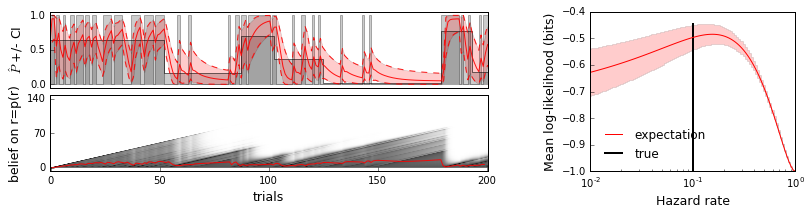

i_block= 1


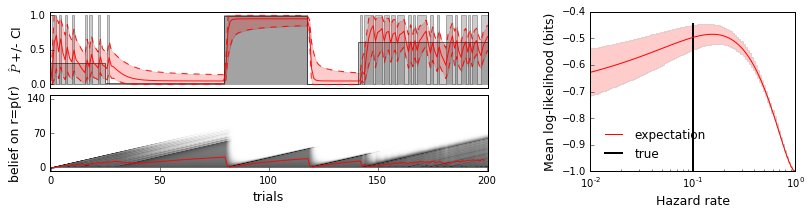

i_block= 2


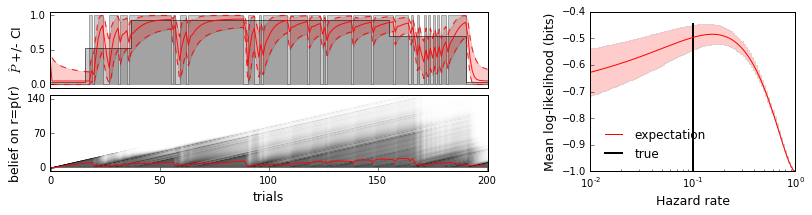

In [8]:
for i_block in range(3):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
    fig, axs = plot_tous(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs,score)
    plt.show()

i_block= 0


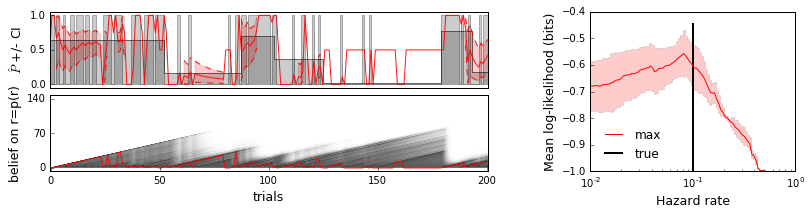

i_block= 1


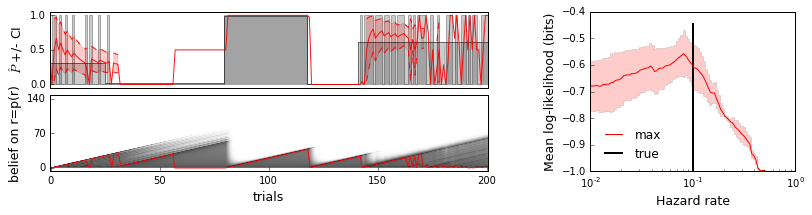

i_block= 2


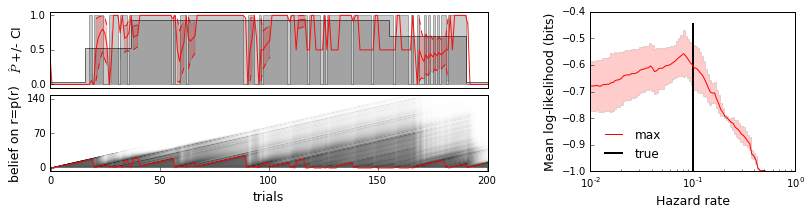

In [9]:
for i_block in range(3):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=.5)
    fig, axs = plot_tous(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs,score, mode='max')
    plt.show()